In [7]:
!pip install xgboost

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="pastel")
# load dataset
df = pd.read_csv('car_data.csv')
df['Selling_Price'] = df['Selling_Price'] * 100000
# using 85 as a standard 2025 exchange rate
df['Selling_Price'] = df['Selling_Price'] / 85
df['Selling_Price'] = df['Selling_Price'].round(2)
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3941.18,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,5588.24,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,8529.41,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,3352.94,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,5411.76,6.87,42450,Diesel,Dealer,Manual,0


RF Predictions: [10294.815     6064.055      726.72644   7552.1294     698.5175
 12256.13      1363.444     3523.7998    6129.631     3225.1946
 10316.142     5256.1187    6776.335     4543.2007     342.91953
    86.803986  9065.052     5892.373     7018.405     9373.589
   622.25195   3465.6042    7734.1665    9693.477     -442.3235
  6129.631     4694.202      937.1241     426.93152    503.82962
   703.9247     503.82962   7152.1875   20380.408    25533.51
  5142.347     4470.3643    1005.0294     500.14462   6707.8286
  6279.5815   10935.421      782.78906   6982.726     8887.323
  5151.788     7019.7236    6129.631     9202.6045    -134.94624
  6065.777     1122.0518    4774.536     6228.762      824.82104
  2182.0579   22995.168      928.5428    5179.7065    7386.54
  -499.72406 ]
Mean Absolute Error: 1463.6428591168512
R^2 Score: 0.8566451011974741


/var/folders/qp/ngj7jjhd1591ql72dcn5wlmw0000gn/T/ipykernel_3334/1756436273.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_data, x='Importance', y='Feature', palette='viridis')


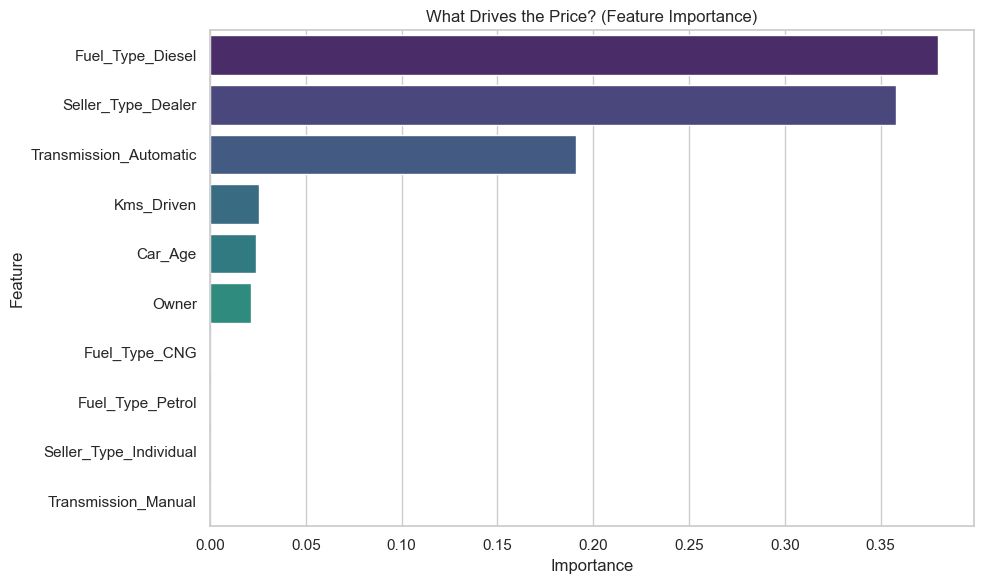

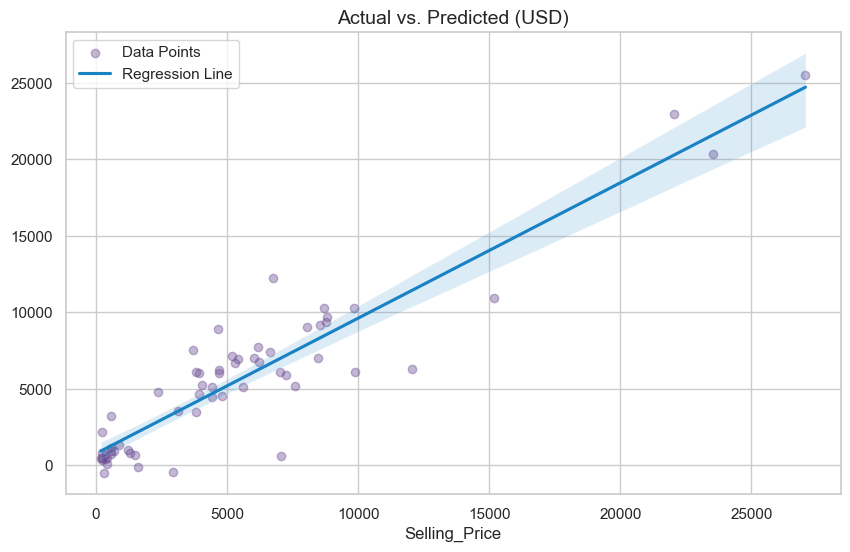

<Figure size 640x480 with 0 Axes>

In [27]:
# new predicator
df["Car_Age"] = 2025 - df["Year"]
# feature selection
y = df['Selling_Price']
numeric_features = ['Car_Age', 'Kms_Driven', 'Owner'] 
categorical_features = ['Fuel_Type', 'Seller_Type', 'Transmission']
X = df[numeric_features + categorical_features]

# train and validation 20/80 split 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=1)
# preprocessing and model pipeline, clean up 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=1,max_depth=4, min_child_weight=1))
])
model_pipeline.fit(X_train, y_train)
predictions = model_pipeline.predict(X_val)
mae = mean_absolute_error(y_val, predictions)
r2 = r2_score(y_val, predictions)
print(f'RF Predictions: {predictions}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}') # r^2 score to determine goodness of regression fit


# bar plot feature importances
importances = model_pipeline.named_steps['regressor'].feature_importances_
ohe_feature_names = model_pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(ohe_feature_names)

# create a sorted DataFrame for a cleaner look
feat_data = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feat_data = feat_data.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_data, x='Importance', y='Feature', palette='viridis')
plt.title("What Drives the Price? (Feature Importance)")
plt.tight_layout()
plt.show()
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.regplot(x=y_val, y=predictions, 
            scatter_kws={'alpha':0.4, 'color':'#6a4c93'}, 
            line_kws={'color':'#1982c4'})                
plt.title("Actual vs. Predicted (USD)", fontsize=14)
plt.legend(['Data Points', 'Regression Line'])
plt.show()
# widening shaded area represents uncertainty in prediction, lower data density 
plt.savefig('actual_vs_predicted.png')

